<a href="https://colab.research.google.com/github/zhiyuan-95/db-vae/blob/main/comet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install comet_ml --quiet
import comet_ml
from comet_ml import API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.2 MB/s eta 0:00:00


what I am trying to do is that I want to prove that the given method can produce a better standard cnn. which means that the validation score would reduce as the increasing epoch.

In [2]:
from functools import partial

EPOCH_PARAM_NAMES = {'batch_size', 'learning_rate','smoothing_fact'}

def _experiment_to_row(e, param_names=None):
    metric_summaries = {sm['name']: sm for sm in e.get_metrics_summary()}
    def mget(name, key, default=np.nan, cast_float=True):
        sm = metric_summaries.get(name)
        if sm is None:
            return default
        val = sm.get(key, default)
        if cast_float and val is not None and not isinstance(val, float):
            try:
                return float(val)
            except Exception:
                return default
        return val

    best_epoch = mget('val', 'stepMax')
    if not np.isnan(best_epoch):best_epoch += 1
    stop_epoch = mget('val', 'stepCurrent')
    if not np.isnan(stop_epoch):stop_epoch += 1

    best_val = mget('val', 'valueMax')
#    loss     = mget('loss', 'valueCurrent')
#    loss_ema = mget('loss_ema', 'valueCurrent')
#    dbval    = mget('dbval', 'valueCurrent')

    row = {
        "exp_key": getattr(e, "key", None),
        "stop_epoch": stop_epoch,
        "best_val"  : best_val,
        "best_epoch": best_epoch,
    }
        # aggregated metrics
 #       "loss"      : np.round(loss, 6),
 #       "loss_ema"  : np.round(loss_ema, 6),
#        "val"       : np.round(val, 6),
#        "dbval"     : np.round(dbval, 6),
        # meta info


    allowed = set(param_names) if param_names is not None else EPOCH_PARAM_NAMES
    params = {}
    for p in e.get_parameters_summary():
        name = p.get("name")
        if name in allowed:
            params[name] = p.get("valueCurrent", None)

    params.update(row)
    return params

def get_param_metric_records(experiments, param_names=None):
    mapper = partial(_experiment_to_row, param_names=param_names)
    rows = list(map(mapper, experiments))
    df = pd.DataFrame(rows)
    df.index = df.index + 1
    return df

In [3]:
def plot(comet,record,y):
    if comet.model == 'dbvae':
        params = [
            ['batch_size', 'learning_rate'],
            ['smoothing_fac','latent_dim']
        ]
        for i in range(len(params)):
            fig, ax = plt.subplots(1, 2, figsize=(10, 4))
            for j in range(len(params[i])):
                ax[j].scatter(record[params[i][j]], record[y])
                ax[j].set_xlabel(params[i][j])
                ax[j].set_ylabel(y)
                ax[j].set_title(f"{params[i][j]} vs. {y}")
                ax[j].grid(True)
            plt.tight_layout(rect=[0, 0, 1, 0.98])
            plt.show()

    elif comet.model == 'standard':
        params = ['batch_size', 'learning_rate']
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        for i in range(len(params)):
            ax[j].scatter(record[params[i][j]], record[y])
            ax[j].set_xlabel(params[i][j])
            ax[j].set_ylabel(y)
            ax[j].set_title(f"{params[i][j]} vs. {y}")
            ax[j].grid(True)
        for sub_ax in fig.get_axes():
            sub_ax.label_outer()
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

In [4]:
# --- 1) pick representative trial per hyperparameter set ---
def pick_representatives(record: pd.DataFrame, by_params):
    # highest best_val wins (since higher is better)
    idx = record.groupby(by_params, dropna=False)['best_val'].idxmax()
    # idx is an Index of row labels (your record index starts from 1)
    return idx.dropna().tolist()
def metrics_at_epoch(exp, epoch, names=('loss_ema','val','dbval')):
    # build per-metric -> {step: value}
    store = {n: {} for n in names}
    for m in exp.get_metrics():
        name = m['metricName']
        if name in store:
            step = int(m['step'])
            store[name][step] = float(m['metricValue'])

    # Some notebooks log epoch starting at 0, some at 1.
    # Try exact epoch first; if missing, try epoch-1 as a fallback.
    out = {}
    for n in names:
        if epoch in store[n]:
            out[n] = store[n][epoch]
        elif (epoch - 1) in store[n]:
            out[n] = store[n][epoch - 1]
        else:
            out[n] = float('nan')
    return out
def build_summary(model, by_params):
    record = model.record
    exps = model.experiments
    # Step 1: pick the best trial for each hyperparameter group
    best_idx = pick_representatives(record,by_params)
    # Step 2: define a helper function that will run on each record
    def get_metrics_for_row(row):
        exp = exps[row.name - 1]  # because record index starts from 1
        best_epoch = int(row['best_epoch'])
        best_val = float(row['best_val'])

        # Extract metrics at that epoch
        metrics = metrics_at_epoch(exp, best_epoch-1, names=('loss_ema','val','dbval'))
        return pd.Series({
            'exp_key': row['exp_key'],
            'loss_at_best': metrics['loss_ema'],
            'val_at_best': metrics['val'],
            'dbval_at_best': metrics['dbval'],
            'best_epoch': best_epoch,
            'best_val': best_val, # it should equal val_at_best, just to check if we got right epoch properly
        })

    # Step 3: apply `map` (or technically pandas `apply`) to selected records
    selected_records = record.loc[best_idx]
    metrics_summary = selected_records.apply(get_metrics_for_row, axis=1)

    # Step 4: merge param columns + metrics summary
    param_cols = record.columns.intersection(by_params)
    summary_df = pd.concat([selected_records[param_cols].reset_index(drop=True),
                            metrics_summary.reset_index(drop=True)], axis=1)

    return summary_df.sort_values(by='val_at_best', ascending=False).reset_index(drop=True)

In [5]:
def get_metric_names(model):
  metricName = []
  for x in model.experiments[0].get_metrics():
    if x['metricName'] not in metricName and x['metricName'][:3]!='sys':
      metricName.append(x['metricName'])
  print(sorted(metricName))

In [38]:
def project_name(c):
  name = 'dbvae-c'
  for x in range(3):
    if len(str(c[x]))==1: name+=f'-{c[x]}'
    else: name+=f'-{str(c[x])[0]}-{str(c[x])[2:]}'
  return name
project_name(c)

'dbvae-c-1-0-2-0-0002'

In [39]:
class comet():
  def __init__(self, model,c=None ,expmt=1):
    COMET_API_KEY = "ROr5Iwf4PjYLL2ZhtmHtYHhoP"
    self.api = API(COMET_API_KEY)
    self.workspace = "zhiyuan-jin"
    self.model = model
    if model == 'standard':
      self.projectName = "Lab2-Part2-standard-new-metrix"
      self.params = ['batch_size', 'learning_rate']
    elif model == 'debiasing':#dbvae-c-1-0-2-0-0002
      self.projectName = project_name(c)
      self.params = ['batch_size', 'learning_rate', 'smoothing_fact']
    try:
      self.experiments = self.api.get(project_name=self.projectName, workspace=self.workspace)
    except Exception as e:
      print(f"Error: Could not find project '{self.projectName}' in workspace '{self.workspace}'. Please check the project name and workspace in Comet ML.")
      raise e
    self.record = get_param_metric_records(self.experiments, self.params)
    self.top_records = None
    self.summary = build_summary(self, self.params)
  def delete_record_comet(self, keys):
    print('are you sure you want to delate following records?: ')
    for x in keys:
      print(x)
    answer = input('')
    if answer == 'yes':
      for key in keys:
        self.api.delete_experiment(key)
        print(f"Deleted experiment {key}")
      self.experiments = self.api.get(project_name=self.projectName, workspace="zhiyuan-jin")
      self.record = get_param_metric_records(self.experiments,self.params)
    else:
      print('not deleted')
  def plot_relation(self, x,y):
    if x == 'learning_rate': X = [float(l) for l in self.summary['learning_rate']]
    elif x == 'batch_size': X = [int(l) for l in self.summary['batch_size']]
    elif y == 'batch_size': Y = [int(l) for l in self.summary['batch_size']]
    else: X = self.summary[x]
    Y = self.summary[y]
    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{x} vs. {y} across Experiments")
    plt.grid(True)
    plt.show()
  def delete_nan_validation(self, confirm=True):
      nan_columns = self.v.columns[self.v.iloc[-1].isna()]
      nan_exps = self.record.loc[nan_columns.to_list()]
      if nan_exps.empty:
          print("✅ No experiments with NaN validation found.")
          return
      print(f"⚠️ Found {len(nan_exps)} experiments with NaN validation:")
      print(nan_exps[['exp_key', 'exp_name', 'validation']])
      if not confirm:
          answer = 'yes'
      else:
          answer = input("Type 'yes' to confirm deletion: ")
      if answer.lower() == 'yes':
          for key in nan_exps['exp_key']:
              try:
                  self.api.delete_experiment(key)
                  print(f"Deleted experiment {key}")
              except Exception as e:
                  print(f"❌ Failed to delete {key}: {e}")
          # Refresh records
          self.experiments = self.api.get(project_name=self.projectName, workspace=self.workspace)
          self.record = get_param_metric_records(self.experiments, self.params)
          print("✅ Refresh complete. Updated experiment list loaded.")
      else:
          print("⏩ Deletion cancelled.")
  def loss_decompose(self,exp):
    total, classification,vae = [],[],[]
    for x in self.experiments[exp].get_metrics():
      if x['metricName']=='loss': total.append(float(x['metricValue']))
      elif x['metricName']=='classification': classification.append(float(x['metricValue']))
      elif x['metricName']=='vae': vae.append(float(x['metricValue']))
    plt.plot(total, label='Total Loss')
    plt.plot(classification, label='classification')
    plt.plot(vae, label='vae')
    plt.legend()
    plt.show()
  def val_trend(self,key):
    val, dbval = [],[]
    for x in self.api.get_experiment_by_key(key).get_metrics():
      if x['metricName']=='val': val.append(float(x['metricValue']))
      elif x['metricName']=='dbval': dbval.append(float(x['metricValue']))
    plt.plot(val, label='val')
    plt.plot(dbval, label='dbval')
    plt.legend()
    plt.show()


In [17]:
def get_avg_dbval_history(model, metric):
    trajectories = []
    print(f"Processing {model.projectName}...")
    # Iterate through the best experiments identified in the summary
    for idx, row in model.summary.iterrows():
        exp_key = row['exp_key']
        best_epoch = row['best_epoch'] # Note: best_epoch was calculated as stepMax + 1

        try:
            # Retrieve the experiment object
            exp = model.api.get_experiment_by_key(exp_key)
            # Fetch all metrics (API call)
            metrics = exp.get_metrics()

            # Filter for 'dbval' and ensure we only take up to the best_epoch
            dbvals = {}
            for m in metrics:
                if m['metricName'] == metric:
                    step = int(m['step'])
                    # Since best_epoch is 1-based (step + 1), we keep steps < best_epoch
                    if step < best_epoch:
                        dbvals[step] = float(m['metricValue'])

            if dbvals:
                trajectories.append(pd.Series(dbvals))

        except Exception as e:
            print(f"Failed to fetch metrics for experiment {exp_key}: {e}")

    if not trajectories:
        print("No trajectory data found.")
        return pd.Series(dtype=float)

    # Combine all series into a DataFrame (aligns by step index)
    # Steps missing in some experiments (due to being shorter) will be NaN
    # We ignore NaNs in the mean calculation, effectively averaging available data
    df = pd.concat(trajectories, axis=1)
    mean_traj = df.mean(axis=1)
    return mean_traj.sort_index()

In [8]:
standard = comet('standard')

In [54]:
#c =(1,0.2,0.0002)
c = (1,1,0.0002)
dbvae = comet('debiasing',c)

In [55]:
dbvae.record

,batch_size,learning_rate,smoothing_fact,exp_key,stop_epoch,best_val,best_epoch
1,40,2.53E-4,0.6,a4493f6cb6c44edaa42e061325fee23d,1.0,0.634418,1.0


In [16]:
standard_summary = standard.summary['dbval_at_best'].describe()
dbvae_summary = dbvae.summary['dbval_at_best'].describe()
combined_summary = pd.DataFrame({'standard': standard_summary, 'dbvae': dbvae_summary})
display(combined_summary)

,standard,dbvae
count,60.000000,36.000000
mean,0.233606,0.255400
std,0.064655,0.095577
min,0.032703,0.072743
25%,0.195053,0.193058
50%,0.231271,0.272026
75%,0.271755,0.331373
max,0.376225,0.402228


Processing Lab2-Part2-standard-new-metrix...
Processing dbvae-c-1-0-2-0-0002...


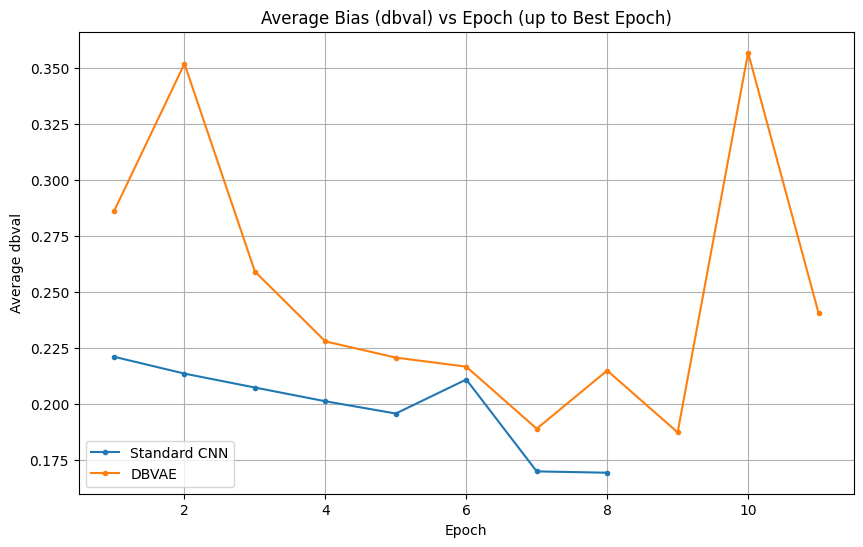

In [22]:
# Calculate average trajectories at each epoch across the experiments
metrix = 'dbval'
std_traj = get_avg_dbval_history(standard, metrix)
dbvae_traj = get_avg_dbval_history(dbvae, metrix)

# Plotting
plt.figure(figsize=(10, 6))
if not std_traj.empty:
    plt.plot(std_traj.index + 1, std_traj.values, label='Standard CNN', marker='.')
if not dbvae_traj.empty:
    plt.plot(dbvae_traj.index + 1, dbvae_traj.values, label='DBVAE', marker='.')

plt.xlabel('Epoch')
plt.ylabel(f'Average {metrix}')
plt.title(f'Average Bias ({metrix}) vs Epoch (up to Best Epoch)')
plt.legend()
plt.grid(True)
plt.show()

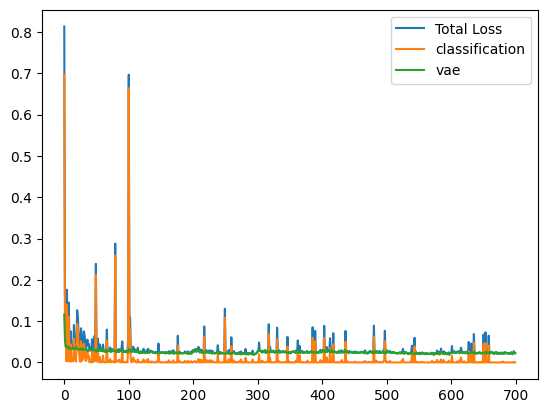

In [12]:
dbvae.loss_decompose(20)